In [15]:
import geopandas as gpd
import ipaddress
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio import plot, CRS
import rasterio.warp
import rasterio.features
import shapely
import shapely.geometry
import shapely.wkt
import yaml
import time
from tqdm import tqdm
import os

from datetime import date, datetime, timedelta, timezone
from shapely import Point, Polygon, MultiPolygon, GeometryCollection, Geometry
from typing import Tuple

from aimlsse_api.client import GroundDataClient, SatelliteDataClient
from aimlsse_api.data import *

Make sure that the file `login.yml` exists. If not, create a new one and store your credentials for the [Copernicus OpenAPI Hub](https://scihub.copernicus.eu/dhus/#/home) in the following form:
```
username: <copernicus-username>
password: <copernicus-password>
```
The file is excluded from git to make sure that credentials are kept private.

In [16]:
login_config = yaml.safe_load(open('login.yml'))
username = login_config['username']
password = login_config['password']
copernicus_login = Credentials(username, password)

In [17]:
target_state = 'California'

In [18]:
data_dir = 'data'
target_dir = os.path.join(data_dir, 'queries', target_state)
features_dir = os.path.join(target_dir, 'features')
preprocessing_dir = os.path.join(target_dir, 'preprocessing')
for dir in [data_dir, target_dir, features_dir, preprocessing_dir]:
    os.makedirs(dir, exist_ok=True)
server_ip = '141.52.225.23'

In [19]:
datetime_from = datetime(2022, 8, 1, tzinfo=timezone.utc)
datetime_to = datetime(2023, 2, 1, tzinfo=timezone.utc)
assert datetime_to.date() > datetime_from.date(), f'Dates must be strictly ordered + \
    \nfrom:\t{datetime_from.date()}\nto:\t{datetime_to.date()}'

In [20]:
station_radius_of_influence = 8000.0 # meters

In [21]:
usa_states: gpd.GeoDataFrame = gpd.read_file('input/us_states_5m.geojson')
usa_states.set_index('NAME', inplace=True)

<class 'shapely.geometry.multipolygon.MultiPolygon'>


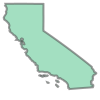

In [22]:
area_of_interest: MultiPolygon = usa_states.loc[target_state].geometry
print(type(area_of_interest))
area_of_interest

In [23]:
def plot_area_of_interest(ax:plt.Axes, color:str):
    gpd.GeoSeries(usa_states.loc[target_state].geometry.buffer(0).boundary).plot(ax=ax, facecolor=color, alpha=1.0, linewidth=0.1, zorder=1)

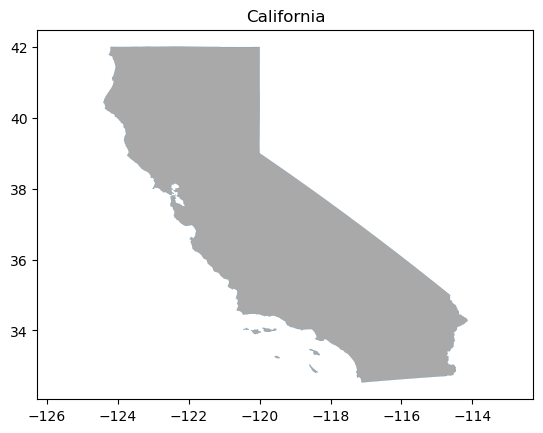

In [24]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title(target_state)
plot_area_of_interest(ax, 'darkgray')

In [40]:
ground_client = GroundDataClient(ipaddress.ip_address(server_ip), 8000)
stations_metadata_filepath = os.path.join(preprocessing_dir, 'station_metadata.csv')
recreate_station_metadata = False
if os.path.exists(stations_metadata_filepath) and not recreate_station_metadata:
    stations_metadata = pd.read_csv(stations_metadata_filepath, index_col=0)
    stations_metadata['geometry'] = stations_metadata['geometry'].apply(shapely.from_wkt)
    stations_metadata = gpd.GeoDataFrame(stations_metadata)
    stations_metadata.set_crs(epsg=4326, inplace=True)
else:
    stations_metadata = ground_client.queryMetadata(polygons=list(area_of_interest.geoms))
    stations_metadata['name'] = stations_metadata['id']
    stations_metadata.set_index('id', inplace=True)
    stations_metadata.to_csv(stations_metadata_filepath)
print(f'Found {len(stations_metadata.index)} stations')

Found 5656 stations


In [41]:
def plot_stations(ax:plt.Axes, color:str):
    stations_metadata.plot(ax=ax, marker='.', color=color, markersize=1)

c:\Users\erikw\anaconda3\lib\site-packages\geopandas\plotting.py:642: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


<Axes: title={'center': 'Station-coverage of California'}>

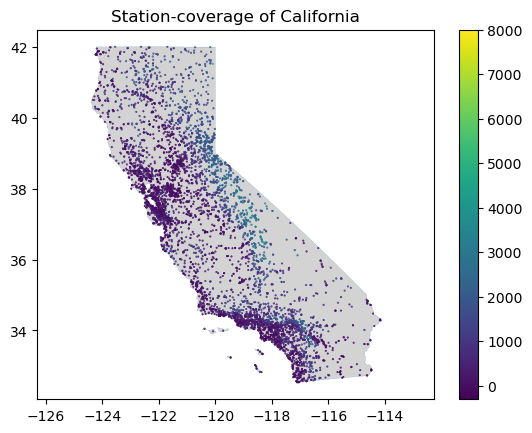

In [42]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title(f'Station-coverage of {target_state}')
plot_area_of_interest(ax, 'lightgray')
stations_metadata.plot('elevation', ax=ax, marker='.', markersize=1, colormap='viridis', legend=True)

In [43]:
satellite_client = SatelliteDataClient(ipaddress.ip_address(server_ip), 8010)
stations_to_sentinel_grid_cells_mapping: gpd.GeoDataFrame = satellite_client.queryContainingGeometry(
    stations_metadata[['name', 'geometry']])
sentinel_grid_cells: gpd.GeoDataFrame = stations_to_sentinel_grid_cells_mapping.drop_duplicates(subset=['cell_name']).copy()
print(f'Found {len(sentinel_grid_cells.index)} grid-cells')

Found 71 grid-cells


In [44]:
def plot_grid_cells(ax:plt.Axes):
    sentinel_grid_cells['geometry'].buffer(0).boundary.plot(ax=ax, edgecolor='black', alpha=0.5, linewidth=0.8, zorder=2)

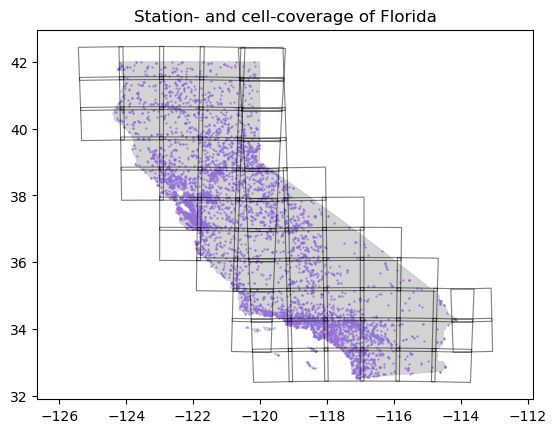

In [45]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title('Station- and cell-coverage of Florida')
plot_area_of_interest(ax, 'lightgray')
plot_stations(ax, 'mediumpurple')
plot_grid_cells(ax)

In [46]:
stations_per_grid_cell = stations_to_sentinel_grid_cells_mapping.groupby('cell_name')['name']
print(f'Average number of stations per grid cell: {stations_per_grid_cell.count().mean()}')

Average number of stations per grid cell: 103.04225352112677


In [48]:
sentinel_products_metadata_filepath = os.path.join(preprocessing_dir, 'sentinel_products_metadata.csv')
os.makedirs(os.path.dirname(sentinel_products_metadata_filepath), exist_ok=True)
if os.path.exists(sentinel_products_metadata_filepath):
    sentinel_products_metadata = pd.read_csv(sentinel_products_metadata_filepath, index_col=0)
else:
    sentinel_products_metadata_list = []
    for cell_name in sentinel_grid_cells['cell_name']:
        sentinel_products_metadata_list += [satellite_client.queryProductsMetadata(datetime_from, datetime_to, copernicus_login,
            cell_name=cell_name
        )]
        time.sleep(1)
    sentinel_products_metadata = pd.concat(sentinel_products_metadata_list)
    sentinel_products_metadata.to_csv(sentinel_products_metadata_filepath)
sentinel_products_metadata['footprint'] = sentinel_products_metadata['footprint'].apply(lambda x: shapely.from_wkt(x))
sentinel_products_metadata['geometry'] = sentinel_products_metadata['footprint']
sentinel_products_metadata = gpd.GeoDataFrame(sentinel_products_metadata)
sentinel_products_metadata.set_crs(epsg=4326, inplace=True)
print(f'Found {len(sentinel_products_metadata.index)} entries')

Found 4631 entries


In [49]:
print(sentinel_products_metadata.columns)

Index(['title', 'link', 'link_alternative', 'link_icon', 'summary', 'ondemand',
       'datatakesensingstart', 'generationdate', 'beginposition',
       'endposition', 'ingestiondate', 'orbitnumber', 'relativeorbitnumber',
       'cloudcoverpercentage', 'sensoroperationalmode', 'gmlfootprint',
       'footprint', 'level1cpdiidentifier', 'tileid', 'hv_order_tileid',
       'format', 'processingbaseline', 'platformname', 'filename',
       'instrumentname', 'instrumentshortname', 'size', 's2datatakeid',
       'producttype', 'platformidentifier', 'orbitdirection',
       'platformserialidentifier', 'processinglevel', 'datastripidentifier',
       'granuleidentifier', 'identifier', 'uuid', 'geometry'],
      dtype='object')


In [50]:
date_columns = ['generationdate', 'ingestiondate']
for col in date_columns:
    sentinel_products_metadata[col] = pd.to_datetime(sentinel_products_metadata[col], unit='ms', utc=True)

In [51]:
sentinel_products_metadata[date_columns]

,generationdate,ingestiondate
41dce797-fa27-4c02-9869-0325207fb1ea,2023-01-27 20:57:59+00:00,2023-01-27 22:47:35.215000+00:00
48d807d2-6fa4-4fd5-9a77-0e19d3dd3327,2023-01-22 20:58:07+00:00,2023-01-22 23:12:29.560000+00:00
d58907a0-4f47-4f2a-bef1-59f4939cab48,2023-01-17 20:55:44+00:00,2023-01-17 22:12:52.132000+00:00
6f58d684-12ca-465a-a003-b768c673569f,2023-01-12 20:58:00+00:00,2023-01-12 23:01:49.382000+00:00
02c92d77-7724-41c9-b564-812c910e1a6e,2023-01-07 20:53:40+00:00,2023-01-07 22:21:25.163000+00:00
...,...,...
5f6b1064-9737-49a5-8f11-425224256b02,2022-08-08 20:19:33+00:00,2022-08-08 23:48:28.810000+00:00
9aeeaa61-620e-45cc-ac65-f76f03dfcdf1,2022-08-05 20:25:38+00:00,2022-08-05 23:07:07.121000+00:00
641b34b0-8798-496e-9824-206c45802535,2022-08-05 20:25:38+00:00,2022-08-05 23:04:24.597000+00:00
e34e7949-65b2-4094-849d-79572e454bc2,2022-08-03 22:08:12+00:00,2022-08-04 02:16:19.375000+00:00


In [52]:
sentinel_products_metadata_per_cell = sentinel_products_metadata.groupby(['tileid'])
sentinel_grid_cells['num_entries'] = sentinel_grid_cells['cell_name'].apply(
    lambda name: len(sentinel_products_metadata_per_cell.get_group(name))
)

<Axes: title={'center': 'Number of sentinel-products per cell'}>

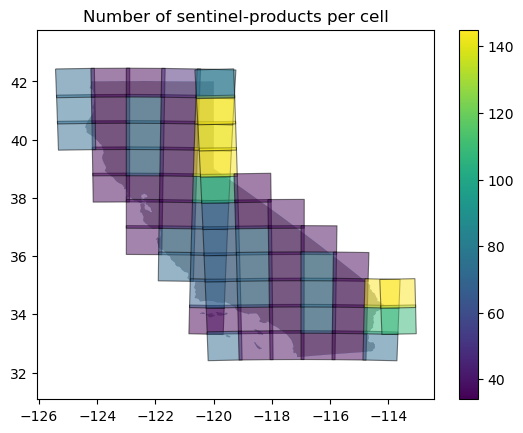

In [53]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title('Number of sentinel-products per cell')
plot_area_of_interest(ax, 'darkgray')
sentinel_grid_cells.plot('num_entries', ax=ax, markersize=0, edgecolor='black', facecolor='red',
    alpha=0.5, linewidth=0.8, legend=True, zorder=2)

In [54]:
products_sorted = sentinel_products_metadata.sort_values(by=['cloudcoverpercentage', 'generationdate'], ascending=[False, True])
products_range_selection = products_sorted[(products_sorted['cloudcoverpercentage'] < 30) | (products_sorted['cloudcoverpercentage'] > 70)].copy()
products_range_selection = products_sorted
print(f'After selection, {len(products_range_selection.index)} of {len(sentinel_products_metadata.index)} products remain')

After selection, 4631 of 4631 products remain


In [55]:
products_range_selection['geometry'] = products_range_selection['footprint']
remaining_grid_cells = products_range_selection.groupby(['tileid'])
print(f'After selection {len(remaining_grid_cells)} of {sentinel_grid_cells.shape[0]} grid cells remain')

After selection 71 of 71 grid cells remain


C:\Users\erikw\AppData\Local\Temp\ipykernel_19940\3631072304.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for label, data in remaining_grid_cells:


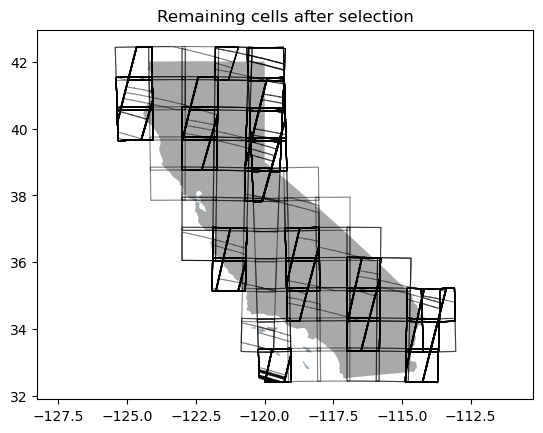

In [56]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title('Remaining cells after selection')
plot_area_of_interest(ax, 'darkgray')
for label, data in remaining_grid_cells:
    gpd.GeoDataFrame(data.drop_duplicates(subset=['geometry'])).plot(ax=ax, markersize=0, edgecolor='black', facecolor='none', alpha=0.5, linewidth=0.8, zorder=2)

In [57]:
def reproject_point(point:Point, crs_from, crs_to) -> Point:
    return Point(rasterio.warp.transform_geom(crs_from, crs_to, point)['coordinates'])

def reproject_polygon(polygon:Polygon, crs_from, crs_to) -> Polygon:
    intermediate = rasterio.warp.transform_geom(crs_from, crs_to, polygon)['coordinates']
    return Polygon(*intermediate)

In [58]:
def sphere_of_influence(point:Point, radius:float, crs) -> Polygon:
    crs_intermediate = CRS.from_epsg(32616)
    return reproject_polygon(reproject_point(point, crs, crs_intermediate).buffer(radius),
        crs_intermediate, crs)

In [59]:
products_range_selection['generationdate']

f749d2e7-0829-42b6-b9c7-76f4b5fb51e0   2022-09-17 22:57:32+00:00
d64a2625-e0f2-4b60-b5eb-aa7c0074d456   2022-09-17 22:57:32+00:00
bda23a38-0bb1-403e-8b37-292ad02b75d0   2022-12-03 19:57:34+00:00
6c1791b1-07ba-4667-8576-38114de6e584   2022-12-03 19:57:34+00:00
6c1791b1-07ba-4667-8576-38114de6e584   2022-12-03 19:57:34+00:00
                                                  ...           
0e22703d-27ac-4202-a51a-fc064588d603   2023-01-28 20:03:44+00:00
1303decc-78e1-439f-bc15-1bc814778d7e   2023-01-28 20:03:44+00:00
ec63bd94-cac8-4957-ae5c-57ec7ebf38c4   2023-01-28 20:03:44+00:00
9c5526a2-8e45-41c5-8300-134215b503e0   2023-01-28 20:03:44+00:00
5bb0f533-5826-4147-8f24-47ff2326bd37   2023-01-31 20:48:55+00:00
Name: generationdate, Length: 4631, dtype: datetime64[ns, UTC]

In [86]:
cloud_covers_order = ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']

In [87]:
cloud_cover_strength = {
    'CLR': 1,
    'SCT': 3,
    'BKN': 5,
    'OVC': 8
}

def get_max_cloud_cover(cloud_covers:List[DataSkyConditions]):
    cloud_covers_ranked = [(cloud_cover_strength[cc.cover],cc.cover) if cc.cover in cloud_cover_strength else (-1,cc.cover) for cc in cloud_covers]
    if any(cloud_covers_ranked):
        return max(cloud_covers_ranked)[1]
    else:
        return None

In [89]:
properties = [
    MetarProperty(MetarPropertyType.TEMPERATURE, UnitTemperature.CELSIUS),
    MetarProperty(MetarPropertyType.CURRENT_WEATHER),
    MetarProperty(MetarPropertyType.RECENT_WEATHER),
    MetarProperty(MetarPropertyType.SKY_CONDITIONS, UnitDistance.METERS),
    MetarProperty(MetarPropertyType.METAR_CODE)
]
properties_str = [str(prop) for prop in properties]

relevant_time_window = timedelta(hours=1)

filter_use_radius = True

all_metars_filepath = os.path.join(preprocessing_dir, 'all_metars.json')
recreate_data = False
if os.path.exists(all_metars_filepath):
    all_metars = pd.read_json(all_metars_filepath, orient='table')
    all_metars = MetarPandas.format_dataframe(all_metars, properties)
    if not set(properties_str).issubset(set(all_metars.columns)):
        # Columns are missing - recreate data
        recreate_data = True
else:
    recreate_data = True
if recreate_data:
    print('Recreating data..')
    all_metars_list = []
    for product_id, product in tqdm(products_range_selection.iterrows(), total=products_range_selection.shape[0]):
        # Query METAR data in relevant_time_range (R) like:
        # [obs_datetime - R/2, obs_datetime + R/2]
        half_time_range = relevant_time_window / 2.0
        product_datetime = product['generationdate']
        query_datetime_from = product_datetime - half_time_range
        query_datetime_to = product_datetime + half_time_range
        stations: gpd.GeoDataFrame = stations_metadata.loc[stations_per_grid_cell.get_group(product['tileid'])]
        product_footprint: shapely.MultiPolygon = product['footprint']
        if filter_use_radius:
            stations = stations[stations['geometry'].apply(
                lambda x: shapely.box(*sphere_of_influence(x, station_radius_of_influence, CRS.from_epsg(4326)).bounds)
                    .within(product_footprint)
            )]
        else:
            stations = stations[stations.within(product_footprint)]
        if not stations.empty:
            try:
                product_metars = ground_client.queryMetar(query_datetime_from, query_datetime_to, properties, stations['name'].to_list())
            except Exception:
                continue
            product_metars['product_id'] = product_id
            all_metars_list += [product_metars]
    all_metars = pd.concat(all_metars_list)
    all_metars.to_json(all_metars_filepath, orient='table', index=False)
still_all_metars = all_metars
all_metars = all_metars[
    all_metars[str(MetarProperty(MetarPropertyType.SKY_CONDITIONS, UnitDistance.METERS))].apply(lambda x: len(x) > 0)
]
all_metars = all_metars[all_metars['sky_conditions [M]'].apply(get_max_cloud_cover).isin(cloud_covers_order)]
metars_per_product = all_metars.groupby(['product_id'])

In [90]:
print(all_metars.shape[0])
print(still_all_metars.shape[0])

9551
9748


In [92]:
remaining_stations = all_metars['station'].drop_duplicates()
print(f'{remaining_stations.shape[0]} remaining stations')
remaining_grid_cells_metars:gpd.GeoDataFrame = stations_to_sentinel_grid_cells_mapping[stations_to_sentinel_grid_cells_mapping['name']
    .isin(remaining_stations)].drop_duplicates(subset=['cell_name'])[['geometry', 'cell_name']].copy()
missing_stations_metadata: gpd.GeoDataFrame = stations_metadata.loc[~stations_metadata.index.isin(remaining_stations)]
missing_stations_metadata = missing_stations_metadata.drop(columns=['index_right'])

125 remaining stations


c:\Users\erikw\anaconda3\lib\site-packages\geopandas\geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


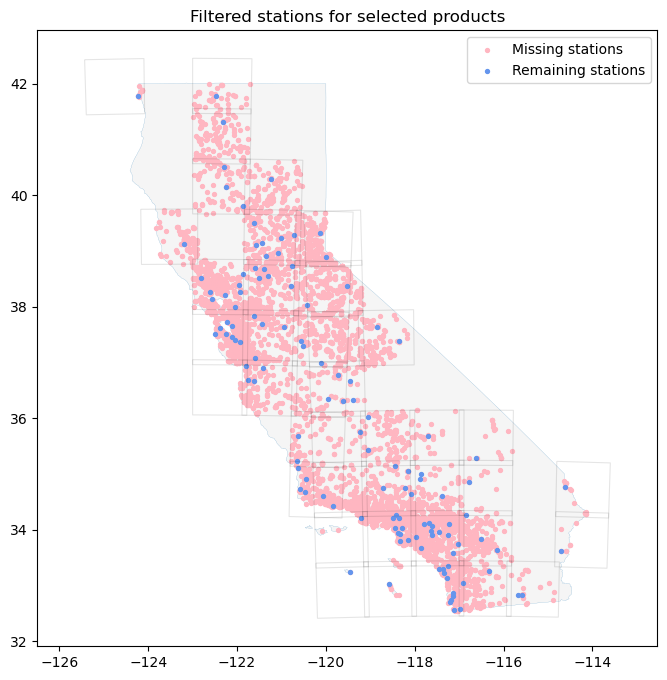

In [93]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal', 'datalim')
ax.set_title('Filtered stations for selected products')
plot_area_of_interest(ax, 'whitesmoke')
remaining_grid_cells_metars.plot(ax=ax, markersize=0, edgecolor='black', facecolor='none', alpha=0.1, linewidth=0.8, zorder=2)
missing_stations_metadata.sjoin(remaining_grid_cells_metars).plot(ax=ax, marker='o', color='lightpink', markersize=8, alpha=1, label='Missing stations')
stations_metadata.loc[remaining_stations].plot(ax=ax, marker='o', color='cornflowerblue', markersize=8, label='Remaining stations')
ax.legend()

In [94]:
products_filtered = sentinel_products_metadata.loc[metars_per_product.groups.keys()]
print('After filtering for the presence of cloud data in METARs and station containment in product footprint,\n'
      f'{len(products_filtered)} of {len(products_range_selection)} products remain '
      f'[{float(len(products_filtered)) / float(len(products_range_selection)) * 100.0:.1f} %]')

After filtering for the presence of cloud data in METARs and station containment in product footprint,
2316 of 4631 products remain [50.0 %]


In [95]:
products_filtered.index

Index(['00065e39-660f-4b17-a4ff-d528b87cef65',
       '002276a1-d3f5-494d-93c8-92e199d63501',
       '004524a1-be24-4363-82be-bc707f79fd2b',
       '0075f903-4865-49a0-8e18-d0f208f3ce2c',
       '007a0e41-5e1d-4529-94d3-784d3acc6c6e',
       '007a0e41-5e1d-4529-94d3-784d3acc6c6e',
       '00bb9773-f695-4c6a-9238-96239be3c681',
       '00ce315c-6b73-4408-9fd3-4dc822774d92',
       '00f56041-00bc-416f-9dac-4f3e504fe081',
       '00f56041-00bc-416f-9dac-4f3e504fe081',
       ...
       'ff4c1688-498e-4d57-b6fc-8793705ae87b',
       'ff6a10c0-bafa-48d3-8d60-4f600f9cde16',
       'ff7b2786-370d-4270-a015-2b17deba4fbf',
       'ff8d7897-70db-4bac-a390-c20b40e61a7e',
       'ffa6a676-52c5-48b6-9c8f-f9cf2df60170',
       'ffb43da1-0854-4eaa-af6c-5347133fbd86',
       'ffb43da1-0854-4eaa-af6c-5347133fbd86',
       'ffcb7dba-8287-4d61-b3f8-268beba9901d',
       'ffef155f-3c61-4e07-a2c4-39a61331917d',
       'ffef155f-3c61-4e07-a2c4-39a61331917d'],
      dtype='object', length=2316)

In [96]:
products_filtered['generationdate'].iloc[0]

Timestamp('2023-01-06 20:38:21+0000', tz='UTC')

In [97]:
pd.set_option('display.max_colwidth', None)
metars_per_product.get_group(products_filtered.index[0])[['station', 'datetime', 'sky_conditions [M]', 'product_id']]

,station,datetime,sky_conditions [M],product_id
9545,BIH,2023-01-06 20:56:00,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",00065e39-660f-4b17-a4ff-d528b87cef65
9546,MMH,2023-01-06 20:18:00,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",00065e39-660f-4b17-a4ff-d528b87cef65
9547,MMH,2023-01-06 20:37:00,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",00065e39-660f-4b17-a4ff-d528b87cef65
9548,MMH,2023-01-06 20:55:00,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",00065e39-660f-4b17-a4ff-d528b87cef65


<Axes: >

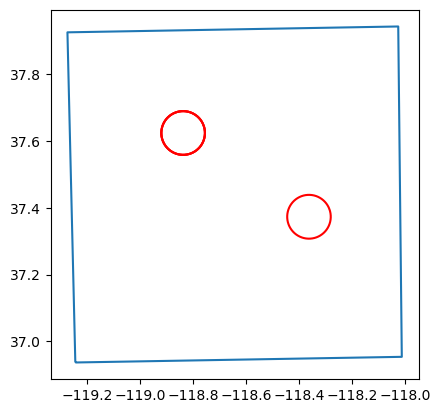

In [98]:
fig, ax = plt.subplots()
product_id_to_plot = products_filtered.index[0]
gpd.GeoDataFrame(pd.DataFrame(sentinel_products_metadata.loc[product_id_to_plot]).T).boundary.plot(ax=ax)
stations_metadata.loc[metars_per_product.get_group(product_id_to_plot)['station']]['geometry'].apply(
    lambda x: sphere_of_influence(x, station_radius_of_influence, CRS.from_epsg(4326)).boundary
).plot(ax=ax, color='red')

In [102]:
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']

os.makedirs(features_dir, exist_ok=True)
products_filtered['state'] = QueryStates.NEW
for product_id in tqdm(products_filtered.index):
    if any(filter(lambda path: path.startswith(product_id), os.listdir(features_dir))):
        # Skip existing files and directories
        continue
    if product_id not in metars_per_product.groups.keys():
        # If no data is available for a tile, skip it
        continue

    product_state = satellite_client.requestProduct(product_id, copernicus_login)
    products_filtered.at[product_id, 'state'] = product_state
    if product_state != QueryStates.AVAILABLE:
        continue

    stations: pd.Series = metars_per_product.get_group(product_id)['station']
    stations = stations.drop_duplicates()
    stations_with_geometry = stations_metadata[stations_metadata['name'].isin(stations)].copy()
    stations_with_geometry['name'] = stations_with_geometry.index
    stations_with_geometry = stations_with_geometry[['name', 'geometry']]
    stations_gdf = gpd.GeoDataFrame(stations_with_geometry)
    stations_gdf.set_crs(crs='EPSG:4326', inplace=True)
    satellite_client.extractFeatures(product_id, station_radius_of_influence, bands, stations_gdf, features_dir)
    time.sleep(1)

 61%|██████▏   | 1423/2316 [50:43<31:49,  2.14s/it]  


KeyboardInterrupt: 

In [39]:
products_filtered.groupby(['state'])['state'].count()

state
QueryStates.AVAILABLE      819
QueryStates.NEW            114
QueryStates.PENDING        136
QueryStates.UNAVAILABLE     89
Name: state, dtype: int64

In [40]:
available_products = products_filtered[products_filtered['state'] == QueryStates.AVAILABLE]
print(f'{available_products.shape[0]} of {products_filtered.shape[0]} products are available [\
{float(available_products.shape[0]) / float(products_filtered.shape[0]) * 100.0:.1f} %]')

819 of 1158 products are available [70.7 %]


In [40]:
available_products['generationdate']

0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9   2022-12-24 17:58:50+00:00
00a749e8-6433-44fd-9e92-0a675372f0c8   2022-11-24 18:16:23+00:00
00f7a487-178b-4d51-b07e-f639cbcbd419   2022-08-13 19:33:28+00:00
026c2797-dbee-4e00-8179-eb0b1868b0eb   2022-10-20 21:08:59+00:00
034b9858-c38a-41a1-88c8-f889c21924fe   2022-08-26 19:47:09+00:00
                                                  ...           
f85e9f15-593a-452d-acf8-0f4d98c9986a   2022-11-22 19:48:18+00:00
fa9ba077-1528-4ad0-a4ac-29ba0eba457f   2022-08-26 19:47:09+00:00
fc2df24c-7b3f-4f91-8ba5-0558375d718d   2022-12-21 17:47:58+00:00
fc5a0c02-e2fa-4150-809c-eb110dc54367   2022-11-27 18:13:38+00:00
ff59ed28-bf5f-4974-baa8-1040c2f45e74   2022-10-30 19:45:23+00:00
Name: generationdate, Length: 104, dtype: datetime64[ns, UTC]

In [41]:
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
os.makedirs(features_dir, exist_ok=True)
ctr = 0
for product_id, row in tqdm(available_products.iterrows(), total=available_products.shape[0]):
    if any(filter(lambda path: path.startswith(product_id), os.listdir(features_dir))):
        # Skip existing files and directories
        ctr += 1
        continue
    if product_id not in metars_per_product.groups.keys():
        # If no data is available for a tile, skip it
        continue
    stations: pd.Series = metars_per_product.get_group(product_id)['station']
    stations = stations.drop_duplicates()
    stations_with_geometry = stations_metadata[stations_metadata['name'].isin(stations)].copy()
    stations_with_geometry['name'] = stations_with_geometry.index
    stations_with_geometry = stations_with_geometry[['name', 'geometry']]
    stations_gdf = gpd.GeoDataFrame(stations_with_geometry)
    stations_gdf.set_crs(crs='EPSG:4326', inplace=True)
    satellite_client.extractFeatures(product_id, station_radius_of_influence, bands, stations_gdf, features_dir)
    ctr += 1
print(ctr)

100%|██████████| 104/104 [06:22<00:00,  3.68s/it]

104


Create a numpy array from METAR data for a single product:

In [42]:
from zipfile import ZipFile
import rasterio
from rasterio import plot, CRS
import rasterio.warp
import rasterio.features
from pathlib import Path
from typing import Dict, List, Tuple
import math

In [43]:
selected_product_id = available_products.iloc[0]['uuid']
print(selected_product_id)

0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9


In [44]:
product_path = os.path.join(features_dir, selected_product_id)
if not os.path.isdir(product_path):
    product_zip_path = product_path + '.zip'
    if not os.path.exists(product_zip_path):
        raise FileExistsError(f'Could not find directory {product_path} or zip-file {product_zip_path}')
    with ZipFile(product_zip_path) as zip_file:
        zip_file.extractall(features_dir)
    os.remove(product_zip_path)

In [45]:
bands = os.listdir(product_path)
print(bands)

['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']


In [46]:
image_drivers = {
    'jp2': 'JP2OpenJPEG'
}

In [47]:
selected_tile = sentinel_products_metadata.loc[selected_product_id]['tileid']
print(f'Tile {selected_tile}')
selected_metars: pd.DataFrame = metars_per_product.get_group(selected_product_id)
selected_stations = selected_metars['station'].drop_duplicates()
print(f'Stations {selected_stations.to_list()}')

Tile 17RNM
Stations ['COF', 'MLB', 'TIX', 'TTS', 'XMR']


In [48]:
bands_with_images: Dict[str, Dict[str, rasterio.DatasetReader]] = {}
for band in bands:
    band_path = os.path.join(product_path, band)
    station_files = os.listdir(band_path)
    bands_with_images[band] = {}
    print(f'Band {band} has station-files: {station_files}')
    for station_file in station_files:
        station_image_path = os.path.join(band_path, station_file)
        station_image = rasterio.open(station_image_path, driver=image_drivers[Path(station_image_path).suffix[1:]])
        station = Path(station_image_path).stem
        bands_with_images[band][station] = station_image

Band B1 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B10 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B11 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B12 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B2 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B3 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B4 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B5 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B6 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B7 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B8 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B8A has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']


Selected station COF with data:
station                                                             COF
datetime                                            2022-12-24 17:55:00
temperature [C]                                                     7.7
current_weather                                                      []
recent_weather                                                       []
sky_conditions [M]    [DataSkyConditions(cover='CLR', height=None, c...
metar_code            KCOF 241755Z AUTO 36007KT 10SM CLR 08/M07 A302...
product_id                         0002c9a0-59c3-4a6c-8fb3-cd494c5fc4b9
Name: 0, dtype: object
Selected band B2


<AxesSubplot: title={'center': 'Station COF - Band B2'}>

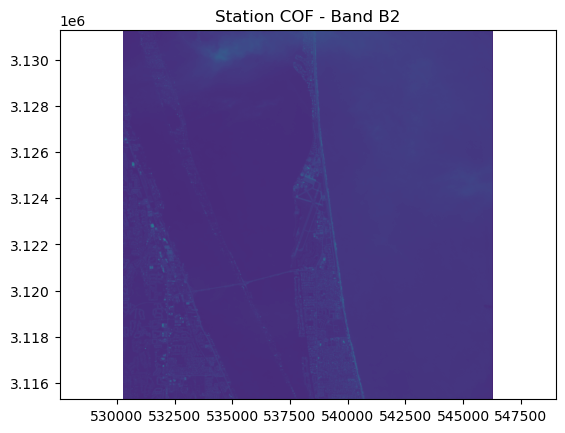

In [49]:
station = selected_stations[0]
station_metadata = stations_metadata.loc[station]
station_metar = selected_metars[selected_metars['station'] == station].iloc[0]
print(f'Selected station {station} with data:\n{station_metar}')
band = 'B2'
print(f'Selected band {band}')

data = bands_with_images[band][station]

fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title(f'Station {station} - Band {band}')
plot.show(data, ax=ax)

In [50]:
data.count

1

In [51]:
data.crs

CRS.from_epsg(32617)

In [52]:
print(data.res)
assert data.res[0] == data.res[1]
resolution = data.res[0]
print(f'Spatial resolution is {resolution} meters per pixel')

(10.0, 10.0)
Spatial resolution is 10.0 meters per pixel


In [53]:
data.shape

(1601, 1601)

In [54]:
station_location: Point = stations_metadata.loc[station]['geometry']
print(f'{CRS.from_epsg(4326)}: {station_location}')
station_location = reproject_point(station_location, CRS.from_epsg(4326), data.crs)
print(f'{data.crs}: {station_location}')

EPSG:4326: POINT (-80.60999 28.23496)
EPSG:32617: POINT (538263.4336502262 3123292.1496769427)


In [55]:
data.bounds

BoundingBox(left=530260.0, bottom=3115290.0, right=546270.0, top=3131300.0)

In [56]:
station_location_relative = Point(
    (data.bounds.right - station_location.x) / (data.bounds.right - data.bounds.left),
    (data.bounds.top - station_location.y) / (data.bounds.top - data.bounds.bottom)
)
print(station_location_relative)
station_location_for_shape = Point(
    station_location_relative.x * data.shape[0],
    station_location_relative.y * data.shape[1]
)
print(station_location_for_shape)

POINT (0.5000978357135405 0.5001780339198794)
POINT (800.6566349773783 800.7850323057269)


In [57]:
fov_angle = 120.0 # degrees
max_cloud_height = 20000.0 # meters
height_delta = max_cloud_height - station_metadata['elevation']
print(f'height_delta: {height_delta}')
influence_radius = math.tan(fov_angle * 0.5) * height_delta
print(f'For a FOV angle of {fov_angle}° and a max cloud-height of {max_cloud_height} meters, the radius of influence is {influence_radius:.1f} meters')

height_delta: 19997.0
For a FOV angle of 120.0° and a max cloud-height of 20000.0 meters, the radius of influence is 6399.8 meters


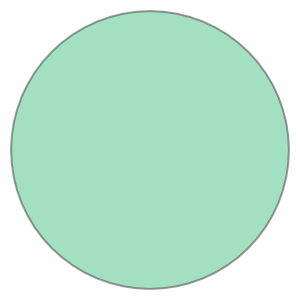

In [58]:
area_of_validity_mask = station_location_for_shape.buffer(6000.0 / resolution)
area_of_validity_mask

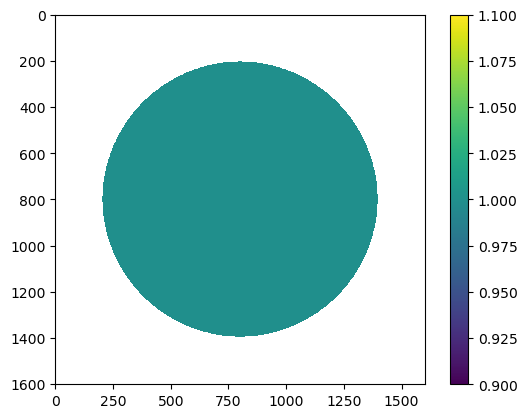

In [59]:
img = rasterio.features.rasterize([area_of_validity_mask], out_shape=data.shape, fill=np.nan)
plt.imshow(img)
plt.colorbar()

In [60]:
img

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [61]:
selected_property = str(properties[0])
print(f'{selected_property}: {station_metar[selected_property]}')

temperature [C]: 7.7


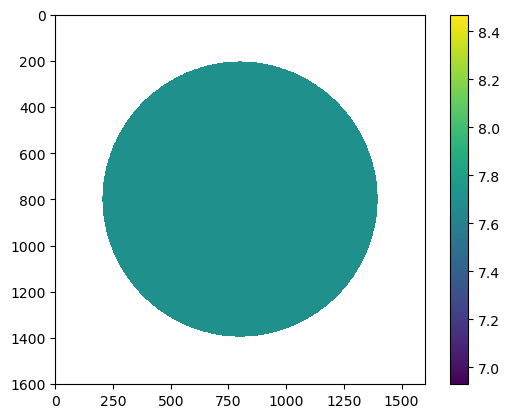

In [62]:
output_data_layer = img * station_metar[selected_property]
plt.imshow(output_data_layer)
plt.colorbar()

In [63]:
output_data_layer

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

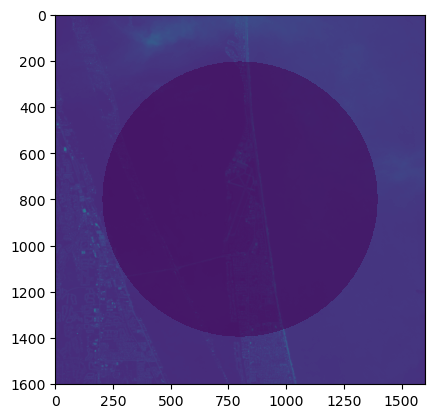

In [64]:
input_data_layer: np.ndarray = data.read(1)

fig, ax = plt.subplots()
ax.imshow(input_data_layer / np.linalg.norm(input_data_layer))
ax.imshow(output_data_layer, alpha=0.5)

In [65]:
np.dstack((input_data_layer, output_data_layer))

array([[[0.000e+00,       nan],
        [1.000e+00,       nan],
        [1.000e+00,       nan],
        ...,
        [2.000e+00,       nan],
        [0.000e+00,       nan],
        [0.000e+00,       nan]],

       [[1.988e+03,       nan],
        [1.969e+03,       nan],
        [1.974e+03,       nan],
        ...,
        [2.588e+03,       nan],
        [2.618e+03,       nan],
        [1.000e+00,       nan]],

       [[1.974e+03,       nan],
        [1.968e+03,       nan],
        [1.971e+03,       nan],
        ...,
        [2.593e+03,       nan],
        [2.613e+03,       nan],
        [0.000e+00,       nan]],

       ...,

       [[1.880e+03,       nan],
        [1.907e+03,       nan],
        [1.975e+03,       nan],
        ...,
        [2.200e+03,       nan],
        [2.190e+03,       nan],
        [0.000e+00,       nan]],

       [[1.892e+03,       nan],
        [1.947e+03,       nan],
        [2.020e+03,       nan],
        ...,
        [2.176e+03,       nan],
        [2.178e+03